# 9h05 - Strategy - Backtesting 

### Import Library

In [27]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

### Load Price Data

In [28]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [29]:
data = dataset.copy()

In [30]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [31]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-12 14:15:00,1306.4,1309.4,1304.6,1304.7,8733
2024-11-12 14:20:00,1304.7,1307.4,1302.7,1306.5,10758
2024-11-12 14:25:00,1306.9,1309.4,1306.2,1309.1,9066


In [32]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]

In [33]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    data['signal'] = data.apply(lambda r: cal_signal(r), axis=1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    return data


def cal_signal(row):
    signal = ''
    if 100 * row.name.hour + row.name.minute != 900:
        return signal
    if row['Low'] == row['Open']:
        signal = 'long'
    elif row['High'] == row['Open']:
        signal = 'short'
    return signal

In [34]:
class FirstBarEntry(Strategy):
    max_sl = 3.1
    trailing_sl = 4.5
    tp_step = 12
    def init(self):
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            sl = buy_price - self.max_sl
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            sl = sell_price + self.max_sl
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [35]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [36]:
bt = Backtest(prepared_data, FirstBarEntry, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [37]:
# bt.plot()
print(stats)

Start                     2020-11-02 09:20:00
End                       2024-11-12 14:45:00
Duration                   1471 days 05:25:00
Exposure Time [%]                    11.23624
Equity Final [$]                  10124.76004
Equity Peak [$]                   10124.76004
Return [%]                             1.2476
Buy & Hold Return [%]                45.84725
Return (Ann.) [%]                     0.31076
Volatility (Ann.) [%]                0.429941
Sharpe Ratio                         0.722797
Sortino Ratio                         1.57288
Calmar Ratio                         0.588557
Max. Drawdown [%]                   -0.528003
Avg. Drawdown [%]                   -0.054284
Max. Drawdown Duration      532 days 23:35:00
Avg. Drawdown Duration       19 days 16:19:00
# Trades                                  310
Win Rate [%]                         35.16129
Best Trade [%]                       1.281611
Worst Trade [%]                     -0.402701
Avg. Trade [%]                    

In [38]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,201,220,912.17357,908.8,-3.37357,-0.003698,2020-11-06 09:05:00,2020-11-06 10:40:00,None,0 days 01:35:00
1,-1,354,401,921.82337,919.5,2.32337,0.002520,2020-11-11 09:05:00,2020-11-11 14:25:00,None,0 days 05:20:00
2,1,405,453,921.77645,926.5,4.72355,0.005124,2020-11-12 09:05:00,2020-11-12 14:30:00,None,0 days 05:25:00
3,-1,607,632,937.71860,937.9,-0.18140,-0.000193,2020-11-18 09:05:00,2020-11-18 11:10:00,None,0 days 02:05:00
4,1,658,698,936.78095,939.2,2.41905,0.002582,2020-11-19 09:05:00,2020-11-19 13:50:00,None,0 days 04:45:00
...,...,...,...,...,...,...,...,...,...,...,...
305,-1,50714,50762,1328.80124,1331.2,-2.39876,-0.001805,2024-10-28 09:05:00,2024-10-28 14:30:00,None,0 days 05:25:00
306,1,50765,50813,1336.00068,1338.2,2.19932,0.001646,2024-10-29 09:05:00,2024-10-29 14:30:00,None,0 days 05:25:00
307,-1,50918,50966,1337.39866,1328.8,8.59866,0.006429,2024-11-01 09:05:00,2024-11-01 14:30:00,None,0 days 05:25:00
308,-1,50969,51006,1330.10085,1318.5,11.60085,0.008722,2024-11-04 09:05:00,2024-11-04 13:35:00,None,0 days 04:30:00


In [39]:
stats['_trades']['PnL'].sum()

124.76004000002195

In [40]:
trades = stats['_trades']

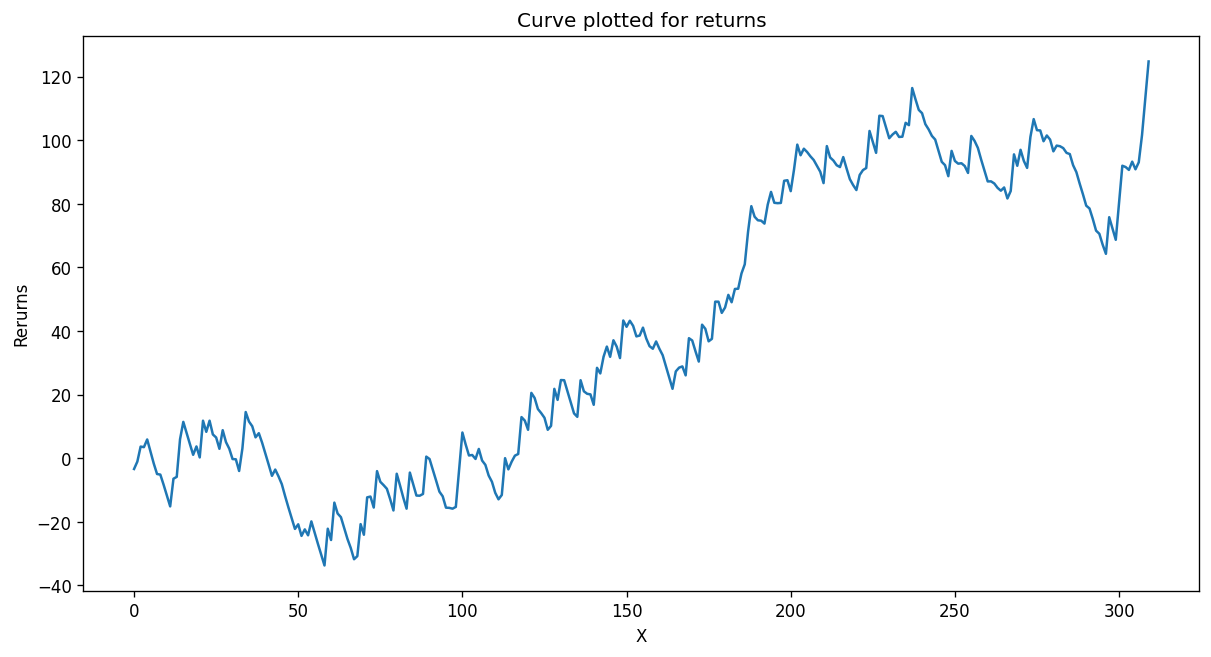

In [41]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()